In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

In [0]:
import pandas as pd
import data_loader as dl
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# **Initializing Lists And Data Loading**

In [0]:
train_features_list = list()
train_label_list = list()
valid_features_list = list()
valid_label_list = list()
test_features_list = list()
test_label_list = list()
label_dict = dict()

In [0]:
def beep():
  from google.colab import output
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')  

In [0]:
df1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/dataset_diabetes/diabetic_data.csv')

In [0]:
train_features_list, train_label_list, valid_features_list, valid_label_list, test_features_list, test_label_list, label_dict = dl.load_dataset('/content/gdrive/My Drive/Colab Notebooks/dataset_diabetes/diabetic_data.csv', valid_rate=0.1)

In [9]:
np.unique(train_label_list)

array([0, 1, 2])

In [10]:
label_dict

{'<30': 1, '>30': 2, 'no': 0}

In [0]:
columns_list = df1.columns
columns_list=columns_list[:-1]

# Converting np array to Data Frames

In [0]:
def conertNpToDF(train_features_list, columns_list):
    df=pd.DataFrame(data=train_features_list,
             columns=columns_list) 
    return df

In [0]:
dfTrain = conertNpToDF(train_features_list, columns_list)
dfValid = conertNpToDF(valid_features_list, columns_list)
dfTest = conertNpToDF(test_features_list, columns_list)

# Feature Engineering

In [0]:
medicines = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

## Plots Showing unknown values

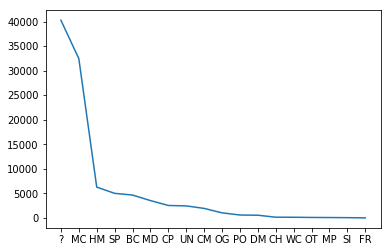

In [17]:
codes=df1['payer_code'].value_counts()
plt.plot(codes.index,codes)
plt.show()

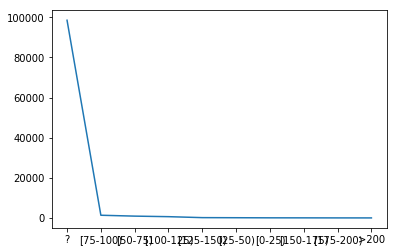

In [18]:
weights = df1['weight'].value_counts()
plt.plot(weights.index,weights)
plt.show()

**Citiglipton and Examide has only 1 value.**

In [19]:
df1['citoglipton'].value_counts()

No    101766
Name: citoglipton, dtype: int64

In [0]:
def basicPreprocess(df):
  
  df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]
  df = df.loc[~df.gender.isin(['Unknown/Invalid'])]
  df = df.replace('?',np.nan)
  
  df = df.drop(['weight','payer_code','medical_specialty', 'diag_2', 'diag_3', 'patient_nbr', 'citoglipton', 'examide'], axis = 1)
  return df

In [0]:
dfTrain1 = basicPreprocess(dfTrain)
dfValid1 = basicPreprocess(dfValid)
dfTest1 = basicPreprocess(dfTest)

In [22]:
dfTest1.shape

(9888, 41)

In [0]:
def recodingPreProcess(df, train_label_list):

  df['admission_type_id'] = df['admission_type_id'].replace(2,1)
  df['admission_type_id'] = df['admission_type_id'].replace(7,1)
  df['admission_type_id'] = df['admission_type_id'].replace(6,5)
  df['admission_type_id'] = df['admission_type_id'].replace(8,5)
  
  df['change'] = df['change'].replace('Ch', 1)
  df['change'] = df['change'].replace('No', 0)
  
  df['gender'] = df['gender'].replace('Male', 1)
  df['gender'] = df['gender'].replace('Female', 0)
  
  df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
  df['diabetesMed'] = df['diabetesMed'].replace('No', 0)
  
  df['race'] = df['race'].fillna('UNK')
  df['diag_1'] = df['diag_1'].fillna('UNK')
  
  df['race'] = df['race'].replace({'Caucasian':0,'AfricanAmerican':1,'UNK':2,'Other':3,'Asian':4,'Hispanic':5})
  
  df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)#Greater than 7 and 
  df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
  df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
  df['A1Cresult'] = df['A1Cresult'].replace('None', -99)
  
  df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
  df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
  df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
  df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)
  
  age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
  df['age'] = df.age.replace(age_id)
  
  for col in medicines:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
    df['numchange'] = 0
    
  for col in medicines:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]
  
  for col in medicines:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)
    
  df['nummed'] = 0
  for col in medicines:
    df['nummed'] = df['nummed'] + df[col]

  return df

In [0]:
dfTrainNew = recodingPreProcess(dfTrain1, train_label_list)
dfValidNew = recodingPreProcess(dfValid1, valid_label_list)
dfTestNew = recodingPreProcess(dfTest1, test_label_list)

In [0]:
def processDiag1(df):
  df['level1_diag1'] = df['diag_1']
# disease codes starting with V or E are in “other” category; so recode them to 0
  df.loc[df['diag_1'].str.contains('V'), ['level1_diag1']] = 0
  df.loc[df['diag_1'].str.contains('E'), ['level1_diag1']] = 0
  # also replace the unknown values with -1
  df['level1_diag1'] = df['level1_diag1'].replace('?', -1)
  df['level1_diag1'] = df['level1_diag1'].replace('UNK', -1)
  
  df['level1_diag1'] = df.level1_diag1.astype('float')
  # iterate and recode disease codes between certain ranges to certain categories
  for index, row in df.iterrows():
    if (row['level1_diag1'] >= 390 and row['level1_diag1'] < 460) or (np.floor(row['level1_diag1']) == 785):
        df.loc[index, 'level1_diag1'] = 1
    elif (row['level1_diag1'] >= 460 and row['level1_diag1'] < 520) or (np.floor(row['level1_diag1']) == 786):
        df.loc[index, 'level1_diag1'] = 2
    elif (row['level1_diag1'] >= 520 and row['level1_diag1'] < 580) or (np.floor(row['level1_diag1']) == 787):
        df.loc[index, 'level1_diag1'] = 3
    elif (np.floor(row['level1_diag1']) == 250):
        df.loc[index, 'level1_diag1'] = 4
    elif (row['level1_diag1'] >= 800 and row['level1_diag1'] < 1000):
        df.loc[index, 'level1_diag1'] = 5
    elif (row['level1_diag1'] >= 710 and row['level1_diag1'] < 740):
        df.loc[index, 'level1_diag1'] = 6
    elif (row['level1_diag1'] >= 580 and row['level1_diag1'] < 630) or (np.floor(row['level1_diag1']) == 788):
        df.loc[index, 'level1_diag1'] = 7
    elif (row['level1_diag1'] >= 140 and row['level1_diag1'] < 240):
        df.loc[index, 'level1_diag1'] = 8
    else:
        df.loc[index, 'level1_diag1'] = 0
# convert this variable to float type to enable computations later
  df['level1_diag1'] = df['level1_diag1'].astype(float)
  
  del df['diag_1']
  
  df['OUTPUT_LABEL'] = pd.Series(train_label_list)
  
  return df

In [0]:
dfTrainNew = processDiag1(dfTrainNew)
dfValidNew = processDiag1(dfValidNew)
dfTestNew = processDiag1(dfTestNew)

In [27]:
dfTrainNew['numchange'].value_counts()

0    58566
1    20780
2     1059
3       85
4        3
Name: numchange, dtype: int64

In [28]:
print(dfTrainNew.groupby('OUTPUT_LABEL').size())
print(dfValidNew.groupby('OUTPUT_LABEL').size())
print(dfTestNew.groupby('OUTPUT_LABEL').size())

OUTPUT_LABEL
0    42577
1     9163
2    28753
dtype: int64
OUTPUT_LABEL
0    4900
1    1027
2    3032
dtype: int64
OUTPUT_LABEL
0    5376
1    1130
2    3382
dtype: int64


In [29]:
dfTrainNew.head()

,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,numchange,nummed,level1_diag1,OUTPUT_LABEL
0,30593184,1,0,90,5,3,17,5,25,0,10,0,0,0,8,0,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0
1,159004950,0,0,60,3,1,1,5,13,4,40,0,0,0,9,-99,-99,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1.0,2
2,38953830,1,0,60,1,1,7,5,51,1,16,0,0,0,9,-99,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,4.0,0
3,23319678,1,1,10,1,1,4,4,13,0,2,0,0,0,1,-99,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,4.0,2
4,134851710,0,1,70,3,1,1,8,22,2,16,0,1,2,9,-99,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2


In [33]:
dfTrainNew.shape

(80493, 44)

In [0]:
new_columns_list = dfTrainNew.columns
new_columns_list=new_columns_list[:-1]

In [35]:
new_columns_list

Index(['encounter_id', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'numchange',
       'nummed', 'level1_diag1'],
      dtype='object')

In [0]:
X_train = dfTrainNew[new_columns_list].values
Y_train = dfTrainNew['OUTPUT_LABEL'].values
X_valid = dfValidNew[new_columns_list].values
Y_valid = dfValidNew['OUTPUT_LABEL'].values
X_test = dfTestNew[new_columns_list].values
Y_test = dfTestNew['OUTPUT_LABEL'].values

In [38]:
print("Training Shape - ", X_train.shape)
print("Validation Shape - ", X_valid.shape)
print("Testing Shape - ", X_test.shape)

Training Shape -  (80493, 43)
Validation Shape -  (8959, 43)
Testing Shape -  (9888, 43)


# Data Transformation

In [39]:
from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
import pickle
from sklearn import metrics
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [0]:
scaler = pickle.load(open(scalerfile, 'rb'))
X_train= scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [42]:
np.unique(Y_train)

array([0, 1, 2])

# Models

# **Extra Code**

In [0]:
# rfcModel = RFC()
# param_grid = [
#   {'max_depth': [5, 10, 15, 20, 30], 'n_estimators': [50, 100, 150, 200], 'min_samples_split' : [0.2, 0.4, 0.6, 0.8]}
#  ]
# featureSelection(rfcModel, param_grid)
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV

# def featureSelection(model, params):

#   model1 = GridSearchCV(model, param_grid=params, n_jobs=-1)
  
#   model1.fit(X_train,Y_train_new)
  
#   print("Best Params:",model1.best_params_)

#   Yhat=model1.predict(X_test)
#   print("Accuracy:",metrics.accuracy_score(Yhat,Y_test))
#   print("Confusion Metrix:\n",metrics.confusion_matrix(Yhat,Y_test))
# rfcBestColumns = ['number_inpatient', 'number_emergency','encounter_id', 'number_outpatient','number_diagnoses','admission_source_id','num_medications', 'nummed','age','level1_diag1']
# X_train_rfc = dfTrainNew[rfcBestColumns].values
# Y_train_rfc = dfTrainNew['OUTPUT_LABEL'].values
# X_valid_rfc = dfValidNew[rfcBestColumns].values
# Y_valid_rfc = dfValidNew['OUTPUT_LABEL'].values
# X_test_rfc = dfTestNew[rfcBestColumns].values
# Y_test_rfc = dfTestNew['OUTPUT_LABEL'].values
# rfcModel = RFC(n_estimators = 10, max_depth = 100, min_samples_split = 0.1)
# rfcModel.fit(X_train_rfc,Y_train_rfc)
# Ypred = rfcModel.predict(X_test_rfc)
# valid_acc.append(metrics.accuracy_score(Y_test_rfc, Ypred))
# print(metrics.confusion_matrix(Ypred,Y_test_rfc))

## Voting Classifier

In [0]:
# from sklearn.ensemble import VotingClassifier
# estimators = [('lr', logreg), ('rfc', rfcModel), ('svm', svmModel)]

# voting = VotingClassifier(estimators,voting='soft',weights=[1,2, 1])
# voting.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=300,
                                                 multi_class='multinomial',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=None,
                                                 solver='saga', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rfc',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion...
                                        

In [0]:
# Y_pred = voting.predict(X_valid)
# print(metrics.accuracy_score(Y_valid, Y_pred))
# print(metrics.confusion_matrix(Y_valid,Y_pred))

0.5084272798303382
[[4074    0  746]
 [ 870    0  178]
 [2610    0  481]]


## CNN

In [0]:
# import numpy as np
# import pandas as pd
# np.random.seed(14)

# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Flatten
# from keras.optimizers import SGD

# from keras.layers import Dropout, Activation, Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling1D
# from keras.layers.normalization import BatchNormalization 
# from keras import regularizers 
# from keras.layers.convolutional import Conv1D

# from sklearn.model_selection import train_test_split
# from matplotlib import pyplot as plt
# from numpy import array

In [0]:
# X_train_np = np.expand_dims(X_train, axis=2)
# print(X_train_np.shape)
# X_test_np = np.expand_dims(X_test, axis=2)
# print(X_test_np.shape)
# n_classes = 3
# Y_trainNN = keras.utils.to_categorical(Y_train, n_classes)
# Y_testNN = keras.utils.to_categorical(Y_test, n_classes)

(80493, 43, 1)
(9888, 43, 1)


In [0]:
# Y_trainNN

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [0]:
# def create_dense():
#     model = Sequential()

#     model.add(Conv1D(32, 3, padding ='same', input_shape=(43,1)))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(2))
    
# #     model.add(Conv1D(64, 3, padding ='same'))
# #     model.add(BatchNormalization())
# #     model.add(Activation('relu'))
# #     model.add(MaxPooling1D(2))
    
#     model.add(Conv1D(64, 3, padding ='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(2))
  
#     model.add(GlobalAveragePooling1D())
  
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(128, activation = 'relu'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(3, activation='softmax'))
    
#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])
#     return model

# def evaluate(model, batch_size=128, epochs=50):
#     model.summary()
#     history = model.fit(X_train_np, Y_trainNN, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_np, Y_testNN))
#     loss, accuracy  = model.evaluate(X_test_np, Y_testNN, verbose=True)
#     print(f'Test loss: {loss:.3}')
#     print(f'Test accuracy: {accuracy:.3}')
#     plt.plot(history.history['acc'])
#     plt.plot(history.history['val_acc'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['training', 'validation'], loc='best')
#     plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 43, 32)            128       
_________________________________________________________________
batch_normalization_41 (Batc (None, 43, 32)            128       
_________________________________________________________________
activation_31 (Activation)   (None, 43, 32)            0         
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 21, 32)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 21, 64)            6208      
_________________________________________________________________
batch_normalization_42 (Batc (None, 21, 64)            256       
_________________________________________________________________
activation_32 (Activation)   (None, 21, 64)            0         
__________

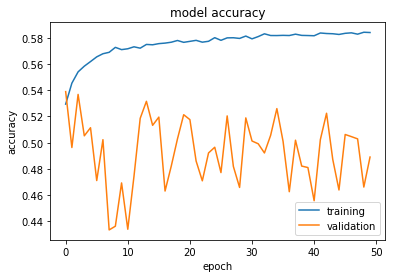

In [0]:
# model = create_dense()
# evaluate(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 43, 32)            128       
_________________________________________________________________
batch_normalization_34 (Batc (None, 43, 32)            128       
_________________________________________________________________
activation_24 (Activation)   (None, 43, 32)            0         
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 21, 32)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 21, 64)            6208      
_________________________________________________________________
batch_normalization_35 (Batc (None, 21, 64)            256       
_________________________________________________________________
activation_25 (Activation)   (None, 21, 64)            0         
__________

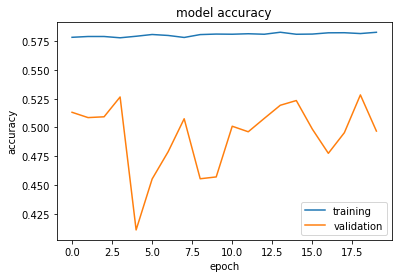

## MLP

In [0]:
# from sklearn.neural_network import MLPClassifier
# mlpModel = MLPClassifier(solver='adam', alpha=0.01,
#                     hidden_layer_sizes=(50,30,50), verbose = True, activation = 'logistic',max_iter=100)

In [0]:
# mlpModel.fit(X_train, Y_train)
# beep()

Iteration 1, loss = 0.95962989
Iteration 2, loss = 0.91076418
Iteration 3, loss = 0.90496750
Iteration 4, loss = 0.90370744
Iteration 5, loss = 0.90272098
Iteration 6, loss = 0.90156731
Iteration 7, loss = 0.90040389
Iteration 8, loss = 0.89937824
Iteration 9, loss = 0.89870407
Iteration 10, loss = 0.89774147
Iteration 11, loss = 0.89727030
Iteration 12, loss = 0.89647014
Iteration 13, loss = 0.89618264
Iteration 14, loss = 0.89532678
Iteration 15, loss = 0.89475924
Iteration 16, loss = 0.89411584
Iteration 17, loss = 0.89375893
Iteration 18, loss = 0.89310256
Iteration 19, loss = 0.89296278
Iteration 20, loss = 0.89213360
Iteration 21, loss = 0.89167908
Iteration 22, loss = 0.89103702
Iteration 23, loss = 0.89076671
Iteration 24, loss = 0.89051984
Iteration 25, loss = 0.89013171
Iteration 26, loss = 0.88949728
Iteration 27, loss = 0.88945059
Iteration 28, loss = 0.88944428
Iteration 29, loss = 0.88826575
Iteration 30, loss = 0.88794771
Iteration 31, loss = 0.88763245
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Accuracy Function

In [0]:
def printMetrics(Y, Ypred):
  print(metrics.accuracy_score(Y, Ypred))
  print("Condusion Matrix - \n", metrics.confusion_matrix(Y,Ypred))

# **Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [0]:
max_depth = [10, 50, 100, 150, 200, 250, 300]
n_estimators =  [5, 10, 15, 20, 30]
minSampleLeaf = [0.1, 0.3, 0.5, 0.7]

rfcModel = RFC(n_estimators = 20,max_depth = 20,  max_leaf_nodes = 5,min_samples_split = 2,max_features = 'sqrt')
rfcModel.fit(X_train,Y_train)
Ytr_pred = rfcModel.predict(X_train)
Yva_pred = rfcModel.predict(X_valid)
Yte_pred = rfcModel.predict(X_test)
print("Training Acc - ")
printMetrics(Y_train, Ytr_pred)
print("Validation Acc - ")
printMetrics(Y_valid, Yva_pred)
print("Test Acc - ")
printMetrics(Y_test, Yte_pred)
beep()

Training Acc - 
0.544954219621582
Condusion Matrix - 
 [[41725     0   852]
 [ 8274     0   889]
 [26613     0  2140]]
Validation Acc - 
0.5289652863042751
Condusion Matrix - 
 [[4590    0  230]
 [ 991    0   57]
 [2942    0  149]]
Test Acc - 
0.5198220064724919
Condusion Matrix - 
 [[4995    0  300]
 [1097    0   54]
 [3297    0  145]]


**Feature Importance**

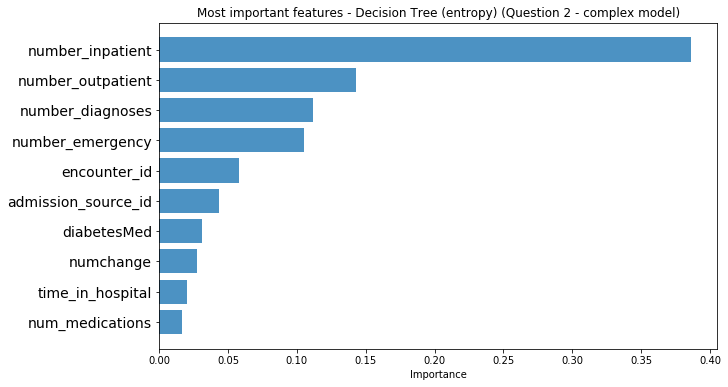

In [0]:
import matplotlib.pyplot as plt

feature_names = new_columns_list
feature_imports = rfcModel.feature_importances_

most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)

plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features for Random Forest')
plt.show()

# SVM

In [0]:
from sklearn import svm
import scipy
svmModel = svm.SVC(kernel = 'sigmoid', verbose = True, class_weight = 'balanced',decision_function_shape = 'ovo',max_iter = 400, random_state = 2, probability = True)
svmModel.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=400, probability=True, random_state=2,
    shrinking=True, tol=0.001, verbose=True)

In [0]:
Ytr_pred = svmModel.predict(X_train)
Yva_pred = svmModel.predict(X_valid)
Yte_pred = svmModel.predict(X_test)
print("Training Acc - ")
printMetrics(Y_train, Ytr_pred)
print("Validation Acc - ")
printMetrics(Y_valid, Yva_pred)
print("Test Acc - ")
printMetrics(Y_test, Yte_pred)
beep()

Training Acc - 
0.5221447827761421
Condusion Matrix - 
 [[33007  2666  6904]
 [ 5247  1570  2346]
 [17323  3978  7452]]
Validation Acc - 
0.4605424712579529
Condusion Matrix - 
 [[3378  454  988]
 [ 719  109  220]
 [2145  307  639]]
Test Acc - 
0.45287216828478966
Condusion Matrix - 
 [[3665  524 1106]
 [ 786  129  236]
 [2431  327  684]]


#Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l1', solver = 'saga', multi_class = 'multinomial',max_iter = 300)
logreg.fit(X_train, Y_train)
beep()

In [0]:
Ytr_pred = logreg.predict(X_train)
Yva_pred = logreg.predict(X_valid)
Yte_pred = logreg.predict(X_test)
print("Training Acc - ")
printMetrics(Y_train, Ytr_pred)
print("Validation Acc - ")
printMetrics(Y_valid, Yva_pred)
print("Test Acc - ")
printMetrics(Y_test, Yte_pred)
beep()

Training Acc - 
0.5681984768861889
Condusion Matrix - 
 [[37418    40  5119]
 [ 5960   108  3095]
 [20441   102  8210]]
Validation Acc - 
0.49614912378613685
Condusion Matrix - 
 [[3811   13  996]
 [ 829    1  218]
 [2451    7  633]]
Test Acc - 
0.48624595469255666
Condusion Matrix - 
 [[4151   15 1129]
 [ 888    4  259]
 [2783    6  653]]


In [0]:
y_train_preds = mlpModel.predict(X_train)
y_valid_preds = mlpModel.predict(X_valid)
y_test_preds = mlpModel.predict(X_test)

In [0]:
from sklearn import metrics
print("Training - " ,metrics.accuracy_score(Y_train, y_train_preds))
print("Validation - ",metrics.accuracy_score(Y_valid, y_valid_preds))
print("Testing - ", metrics.accuracy_score(Y_test,y_test_preds))
print(metrics.confusion_matrix(Y_train, y_train_preds))
print(metrics.confusion_matrix(Y_valid, y_valid_preds))
#print(metrics.confusion_matrix(y_train_preds,Y_train))

Training -  0.590771868361224
Validation -  0.48811251255720506
Testing -  0.4851334951456311
[[  228   176    58]
 [ 3771 12019  7213]
 [ 5164 16558 35306]]
[[   7   20   36]
 [ 313  878 1311]
 [ 701 2205 3488]]


# Neural Network

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD

from keras.layers import Dropout 
from keras.layers.normalization import BatchNormalization 
from keras import regularizers 
from keras.layers.convolutional import Conv1D

Using TensorFlow backend.


**Expand the dimension for Y because of neural network**

In [0]:
n_classes = 3
Y_trainNN = keras.utils.to_categorical(Y_train, n_classes)
Y_testNN = keras.utils.to_categorical(Y_test, n_classes)
Y_validNN = keras.utils.to_categorical(Y_valid, n_classes)

In [46]:
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(43,)))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

W0614 02:08:05.931791 139826532697984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 02:08:05.979566 139826532697984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 02:08:05.986172 139826532697984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0614 02:08:06.081544 139826532697984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0614 02:08:06.339327 

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2816      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
__________

In [48]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.00125), metrics=['accuracy'])

W0614 02:08:10.375074 139826532697984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0614 02:08:10.383268 139826532697984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [49]:
history = model.fit(X_train, Y_trainNN, batch_size=32, epochs=30, verbose=1, validation_data=(X_valid, Y_validNN))
# beep()

W0614 02:08:11.977446 139826532697984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 80493 samples, validate on 8959 samples
Epoch 1/30
80493/80493 [==============================] - 24s 294us/step - loss: 1.1933 - acc: 0.4560 - val_loss: 0.9889 - val_acc: 0.4973
Epoch 2/30
80493/80493 [==============================] - 19s 232us/step - loss: 0.9943 - acc: 0.5043 - val_loss: 0.9719 - val_acc: 0.5400
Epoch 3/30
80493/80493 [==============================] - 19s 231us/step - loss: 0.9615 - acc: 0.5246 - val_loss: 0.9653 - val_acc: 0.5463
Epoch 4/30
80493/80493 [==============================] - 18s 228us/step - loss: 0.9497 - acc: 0.5344 - val_loss: 0.9654 - val_acc: 0.5441
Epoch 5/30
80493/80493 [==============================] - 18s 226us/step - loss: 0.9434 - acc: 0.5354 - val_loss: 0.9654 - val_acc: 0.5431
Epoch 6/30
80493/80493 [==============================] - 18s 226us/step - loss: 0.9403 - acc: 0.5362 - val_loss: 0.9644 - val_acc: 0.5417
Epoch 7/30
80493/80493 [==============================] - 18s 227us/step - loss: 0.9362 - acc: 0.5368 - val_loss: 0.9

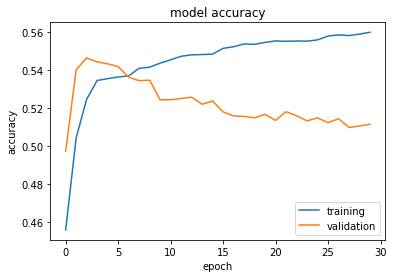

Validation accuracy: 0.511
Test accuracy: 0.51


In [51]:
import matplotlib.pyplot as plt
loss, accuracy  = model.evaluate(X_valid, Y_validNN, verbose=False)
lossTest, accuracyTest  = model.evaluate(X_test, Y_testNN, verbose=False)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Validation accuracy: {accuracy:.3}')
print(f'Test accuracy: {accuracyTest:.3}')